In [2]:
import os
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
auth = earthaccess.login()
# are we authenticated?
if auth.authenticated:
    print("authenticated!")
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

authenticated!


In [4]:
results = earthaccess.search_datasets(instrument="oci")

In [6]:
for item in results:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L2_BGC_NRT
PACE_OCI_L0_SCI
PACE_OCI_L1A_SCI
PACE_OCI_L1B_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_PAR_NRT
PACE_OCI_L3B_CHL_NRT
PACE_OCI_L3B_IOP_NRT
PACE_OCI_L3B_KD_NRT
PACE_OCI_L3B_PAR_NRT
PACE_OCI_L3B_POC_NRT
PACE_OCI_L3B_RRS_NRT
PACE_OCI_L3M_CHL_NRT
PACE_OCI_L3M_IOP_NRT
PACE_OCI_L3M_KD_NRT
PACE_OCI_L3M_PAR_NRT
PACE_OCI_L3M_POC_NRT
PACE_OCI_L3M_RRS_NRT


In [5]:
tspan = ("2024-07-01", "2024-08-25")
bbox = (-170, 23, -140, 33)

In [6]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS_NRT",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*.0p1deg.*",
)

paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/56 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/56 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
paths

In [17]:
import xarray as xr

# Use dask for lazy loading
combined_datasets = []

# Iterate over all the datasets
for i in range(1, len(paths)):
    # Open dataset without specifying chunks
    dataset = xr.open_dataset(paths[i])  # Load the dataset first

    # Rechunk the dataset after loading
    dataset = dataset.chunk({'lon': 'auto', 'lat': 'auto'})  # Use 'auto' or set specific sizes
    
    # Subset the dataset within the specified region and append to list
    subset = dataset.sel(lon=slice(-159.5, -157.5), lat=slice(27.5, 26))
    combined_datasets.append(subset)

# Concatenate all subsets along the 'dataset' dimension
combined_dataset = xr.concat(combined_datasets, dim='dataset')

# Calculate the mean Rrs value across lon and lat for each dataset
average_per_dataset = combined_dataset.mean(dim=['lon', 'lat'])

In [18]:
average_per_dataset

<xarray.Dataset> Size: 84kB
Dimensions:     (wavelength: 184, dataset: 55, rgb: 3, eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 339.0 341.0 344.0 ... 714.0 717.0 719.0
Dimensions without coordinates: dataset, rgb, eightbitcolor
Data variables:
    Rrs         (dataset, wavelength) float32 40kB dask.array<chunksize=(1, 184), meta=np.ndarray>
    palette     (dataset, rgb, eightbitcolor) uint8 42kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>

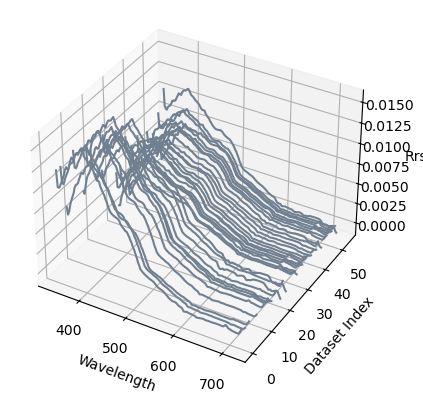

In [22]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Loop over the dataset dimension to extract the data for plotting
for dataset_index in range(average_per_dataset.sizes['dataset']):
    # Extract the wavelengths and Rrs values for this dataset
    wavelengths = average_per_dataset['wavelength'].values
    rrs_values = average_per_dataset.isel(dataset=dataset_index)['Rrs'].values
    
    # Use the dataset_index as the y-coordinate
    y = np.full_like(wavelengths, dataset_index)
    
    # Plot in 3D space using a single color (e.g., slategray)
    ax.plot(wavelengths, y, rrs_values, color='slategray')

# Set axis labels
ax.set_xlabel('Wavelength')
ax.set_ylabel('Days since 2024-07-01')
ax.set_zlabel('Rrs')

# Rotate the plot 45 degrees along the Y-axis
ax.view_init(elev=35, azim=-60)

# Show the plot
plt.show()
